In [21]:
from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data
from epimodel.preprocessing.preprocessed_data import PreprocessedData
from epimodel.pymc3_models.base_model import produce_CIs
import numpy as np
import pymc3 as pm
from pymc3.distributions import draw_values, generate_samples

import pandas as pd 
import pickle 

In [2]:
import pylab as plt
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/Users/jsalvatier/Library/Caches/pypoetry/virtualenvs/epimodel-Y5DpXmSQ-py3.8/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
data = preprocess_data('../double-entry-data/double_entry_final.csv', last_day='2020-05-30', smoothing=1)
data.mask_reopenings(print_out = False)

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [4]:
ep = EpidemiologicalParameters()

In [5]:
with DefaultModel(data) as model_syn:
    model_syn.build_model(**ep.get_model_build_dict())

In [ ]:
with model_syn: 
    
    point = {
        'CM_Alpha' : np.array([0,0,0,0,0,.1,.9,.9,.9]),
        'InitialSizeCases_log' : -10 *np.ones((41,1)), 
        'InitialSizeDeaths_log' : -10 *np.ones((41,1)), 
        'RegionLogR_noise' : .1*np.ones(41),
        'HyperRVar' : 1
    }
    c = [model_syn.GrowthCases, 
         model_syn.GrowthDeaths, 
         model_syn.RegionR, 
         model_syn.ObservedCases, 
         model_syn.ObservedDeaths, 
         model_syn.RegionLogR_noise, 
         model_syn.InfectedCases ,
         model_syn.InfectedDeaths ,
         model_syn.ExpectedCases ,
         model_syn.ExpectedDeaths ]
    
    synthvalues = draw_values(c, point=point)
    gcases,gdeaths, regionR, ocases, odeaths, regionRnoise,icases,ideaths,ecases, edeaths = synthvalues
    

In [23]:
with open("synthetic_values.pkl", 'wb+') as f:
    pickle.dump(synthvalues, f, pickle.HIGHEST_PROTOCOL)

In [7]:
def synthetic_prep_data(model, data, syn_deaths, syn_cases):
    
    def reverse_shape(synth, indexes, mask):
        a = np.zeros(model.nRs * model.nDs)
        a[indexes] += synth
        a = a.reshape((model.nRs, model.nDs))
        a = np.ma.masked_array(a, mask)
        return a

    
    syntheticNewDeaths = reverse_shape(syn_deaths, 
                                       model.all_observed_deaths,  
                                       data.NewDeaths.mask)
    syntheticNewCases = reverse_shape(syn_cases, 
                              model.all_observed_active,  
                              data.NewCases.mask)
    
    return PreprocessedData(
                 data.Active,
                 data.Confirmed,
                 data.ActiveCMs,
                 data.CMs,
                 data.Rs,
                 data.Ds,
                 data.Deaths,
                 syntheticNewDeaths,
                 syntheticNewCases,
                 data.RNames)




In [8]:
adjustment = np.array([ np.random.choice([.5, 2]) for i in range(model_syn.nRs)])

In [9]:
synth_data_normal = synthetic_prep_data(model_syn, data, odeaths, ocases)
synth_data_adjusted = synthetic_prep_data(model_syn, data, odeaths, ocases)
synth_data_adjusted.NewCases  = synth_data_adjusted.NewCases * adjustment[:, None]

In [10]:
with DefaultModel(synth_data_normal) as model_normal:
    model_normal.build_model(**ep.get_model_build_dict())

In [18]:
with model_normal:
    model_normal.trace = pm.sample(200, tune=50, cores=1, chains=1, max_treedepth=12, target_accept=0.925)
    pm.save_trace(model_normal.trace, "normal", overwrite=True)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [DeathsDelayDisp, DeathsDelayMean, InitialSizeDeaths_log, CasesDelayDisp, CasesDelayMean, InitialSizeCases_log, PsiDeaths, PsiCases, GrowthDeathsNoise, GrowthCasesNoise, GI_sd, GI_mean, RegionLogR_noise, HyperRVar, CM_Alpha]


Sampling 1 chain for 50 tune and 200 draw iterations (50 + 200 draws total) took 532 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [19]:
with DefaultModel(synth_data_adjusted) as model_adjusted:
    model_adjusted.build_model(**ep.get_model_build_dict())

In [20]:
with model_adjusted:
    model_adjusted.trace = pm.sample(200, tune=50, cores=1, chains=1, max_treedepth=12, target_accept=0.925)
    pm.save_trace(model_adjusted.trace, "adjusted", overwrite=True)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [DeathsDelayDisp, DeathsDelayMean, InitialSizeDeaths_log, CasesDelayDisp, CasesDelayMean, InitialSizeCases_log, PsiDeaths, PsiCases, GrowthDeathsNoise, GrowthCasesNoise, GI_sd, GI_mean, RegionLogR_noise, HyperRVar, CM_Alpha]


Sampling 1 chain for 50 tune and 200 draw iterations (50 + 200 draws total) took 1087 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [19]:
ascertainment = pd.read_csv("../double-entry-data/under_ascertainment_estimates.txt")

In [29]:
country_codes = {
    "AFG":"AF",
"ALA":"AX",
"ALB":"AL",
"DZA":"DZ",
"ASM":"AS",
"AND":"AD",
"AGO":"AO",
"AIA":"AI",
"ATA":"AQ",
"ATG":"AG",
"ARG":"AR",
"ARM":"AM",
"ABW":"AW",
"AUS":"AU",
"AUT":"AT",
"AZE":"AZ",
"BHS":"BS",
"BHR":"BH",
"BGD":"BD",
"BRB":"BB",
"BLR":"BY",
"BEL":"BE",
"BLZ":"BZ",
"BEN":"BJ",
"BMU":"BM",
"BTN":"BT",
"BOL":"BO",
"BES":"BQ",
"BIH":"BA",
"BWA":"BW",
"BVT":"BV",
"BRA":"BR",
"IOT":"IO",
"BRN":"BN",
"BGR":"BG",
"BFA":"BF",
"BDI":"BI",
"CPV":"CV",
"KHM":"KH",
"CMR":"CM",
"CAN":"CA",
"CYM":"KY",
"CAF":"CF",
"TCD":"TD",
"CHL":"CL",
"CHN":"CN",
"CXR":"CX",
"CCK":"CC",
"COL":"CO",
"COM":"KM",
"COD":"CD",
"COG":"CG",
"COK":"CK",
"CRI":"CR",
"CIV":"CI",
"HRV":"HR",
"CUB":"CU",
"CUW":"CW",
"CYP":"CY",
"CZE":"CZ",
"DNK":"DK",
"DJI":"DJ",
"DMA":"DM",
"DOM":"DO",
"ECU":"EC",
"EGY":"EG",
"SLV":"SV",
"GNQ":"GQ",
"ERI":"ER",
"EST":"EE",
"SWZ":"SZ",
"ETH":"ET",
"FLK":"FK",
"FRO":"FO",
"FJI":"FJ",
"FIN":"FI",
"FRA":"FR",
"GUF":"GF",
"PYF":"PF",
"ATF":"TF",
"GAB":"GA",
"GMB":"GM",
"GEO":"GE",
"DEU":"DE",
"GHA":"GH",
"GIB":"GI",
"GRC":"GR",
"GRL":"GL",
"GRD":"GD",
"GLP":"GP",
"GUM":"GU",
"GTM":"GT",
"GGY":"GG",
"GIN":"GN",
"GNB":"GW",
"GUY":"GY",
"HTI":"HT",
"HMD":"HM",
"VAT":"VA",
"HND":"HN",
"HKG":"HK",
"HUN":"HU",
"ISL":"IS",
"IND":"IN",
"IDN":"ID",
"IRN":"IR",
"IRQ":"IQ",
"IRL":"IE",
"IMN":"IM",
"ISR":"IL",
"ITA":"IT",
"JAM":"JM",
"JPN":"JP",
"JEY":"JE",
"JOR":"JO",
"KAZ":"KZ",
"KEN":"KE",
"KIR":"KI",
"PRK":"KP",
"KOR":"KR",
"KWT":"KW",
"KGZ":"KG",
"LAO":"LA",
"LVA":"LV",
"LBN":"LB",
"LSO":"LS",
"LBR":"LR",
"LBY":"LY",
"LIE":"LI",
"LTU":"LT",
"LUX":"LU",
"MAC":"MO",
"MKD":"MK",
"MDG":"MG",
"MWI":"MW",
"MYS":"MY",
"MDV":"MV",
"MLI":"ML",
"MLT":"MT",
"MHL":"MH",
"MTQ":"MQ",
"MRT":"MR",
"MUS":"MU",
"MYT":"YT",
"MEX":"MX",
"FSM":"FM",
"MDA":"MD",
"MCO":"MC",
"MNG":"MN",
"MNE":"ME",
"MSR":"MS",
"MAR":"MA",
"MOZ":"MZ",
"MMR":"MM",
"NAM":"NA",
"NRU":"NR",
"NPL":"NP",
"NLD":"NL",
"NCL":"NC",
"NZL":"NZ",
"NIC":"NI",
"NER":"NE",
"NGA":"NG",
"NIU":"NU",
"NFK":"NF",
"MNP":"MP",
"NOR":"NO",
"OMN":"OM",
"PAK":"PK",
"PLW":"PW",
"PSE":"PS",
"PAN":"PA",
"PNG":"PG",
"PRY":"PY",
"PER":"PE",
"PHL":"PH",
"PCN":"PN",
"POL":"PL",
"PRT":"PT",
"PRI":"PR",
"QAT":"QA",
"REU":"RE",
"ROU":"RO",
"RUS":"RU",
"RWA":"RW",
"BLM":"BL",
"SHN":"SH",
"KNA":"KN",
"LCA":"LC",
"MAF":"MF",
"SPM":"PM",
"VCT":"VC",
"WSM":"WS",
"SMR":"SM",
"STP":"ST",
"SAU":"SA",
"SEN":"SN",
"SRB":"RS",
"SYC":"SC",
"SLE":"SL",
"SGP":"SG",
"SXM":"SX",
"SVK":"SK",
"SVN":"SI",
"SLB":"SB",
"SOM":"SO",
"ZAF":"ZA",
"SGS":"GS",
"SSD":"SS",
"ESP":"ES",
"LKA":"LK",
"SDN":"SD",
"SUR":"SR",
"SJM":"SJ",
"SWE":"SE",
"CHE":"CH",
"SYR":"SY",
"TWN":"TW",
"TJK":"TJ",
"TZA":"TZ",
"THA":"TH",
"TLS":"TL",
"TGO":"TG",
"TKL":"TK",
"TON":"TO",
"TTO":"TT",
"TUN":"TN",
"TUR":"TR",
"TKM":"TM",
"TCA":"TC",
"TUV":"TV",
"UGA":"UG",
"UKR":"UA",
"ARE":"AE",
"GBR":"GB",
"UMI":"UM",
"USA":"US",
"URY":"UY",
"UZB":"UZ",
"VUT":"VU",
"VEN":"VE",
"VNM":"VN",
"VGB":"VG",
"VIR":"VI",
"WLF":"WF",
"ESH":"EH",
"YEM":"YE",
"ZMB":"ZM",
"ZWE":"ZW"
}

In [30]:
ascertainment['region'] = ascertainment.iso_code.map(country_codes)
ascertainment

,Unnamed: 0,date,country,iso_code,median,lower_95_CrI,upper_95_CrI,region
0,1,2020-03-26,Afghanistan,AFG,0.219475,0.135103,0.328435,AF
1,2,2020-03-27,Afghanistan,AFG,0.216930,0.135517,0.323208,AF
2,3,2020-03-28,Afghanistan,AFG,0.214652,0.136513,0.318191,AF
3,4,2020-03-29,Afghanistan,AFG,0.212665,0.137439,0.313888,AF
4,5,2020-03-30,Afghanistan,AFG,0.210997,0.138818,0.308710,AF
...,...,...,...,...,...,...,...,...
19588,19589,2020-08-07,Zimbabwe,ZWE,0.422877,0.334797,0.536267,ZW
19589,19590,2020-08-08,Zimbabwe,ZWE,0.424188,0.334477,0.542613,ZW
19590,19591,2020-08-09,Zimbabwe,ZWE,0.425488,0.333749,0.548394,ZW
19591,19592,2020-08-10,Zimbabwe,ZWE,0.426773,0.332978,0.554131,ZW


In [21]:
data.Rs

['AL',
 'AD',
 'AT',
 'BE',
 'BA',
 'BG',
 'HR',
 'CZ',
 'DK',
 'EE',
 'FI',
 'FR',
 'GE',
 'DE',
 'GR',
 'HU',
 'IS',
 'IE',
 'IL',
 'IT',
 'LV',
 'LT',
 'MY',
 'MT',
 'MX',
 'MA',
 'NL',
 'NZ',
 'NO',
 'PL',
 'PT',
 'RO',
 'RS',
 'SG',
 'SK',
 'SI',
 'ZA',
 'ES',
 'SE',
 'CH',
 'GB']

In [14]:
with model:
    model.trace = pm.load_trace("synthetic")

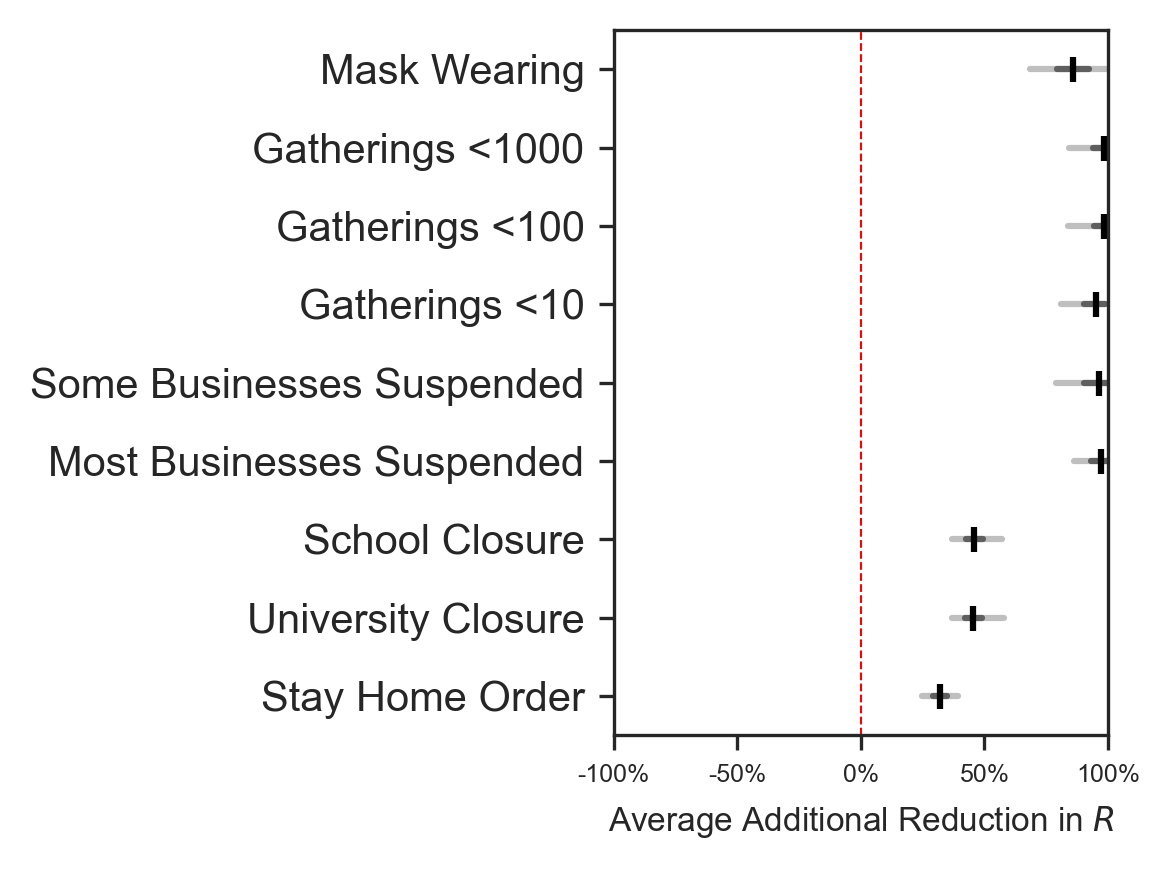

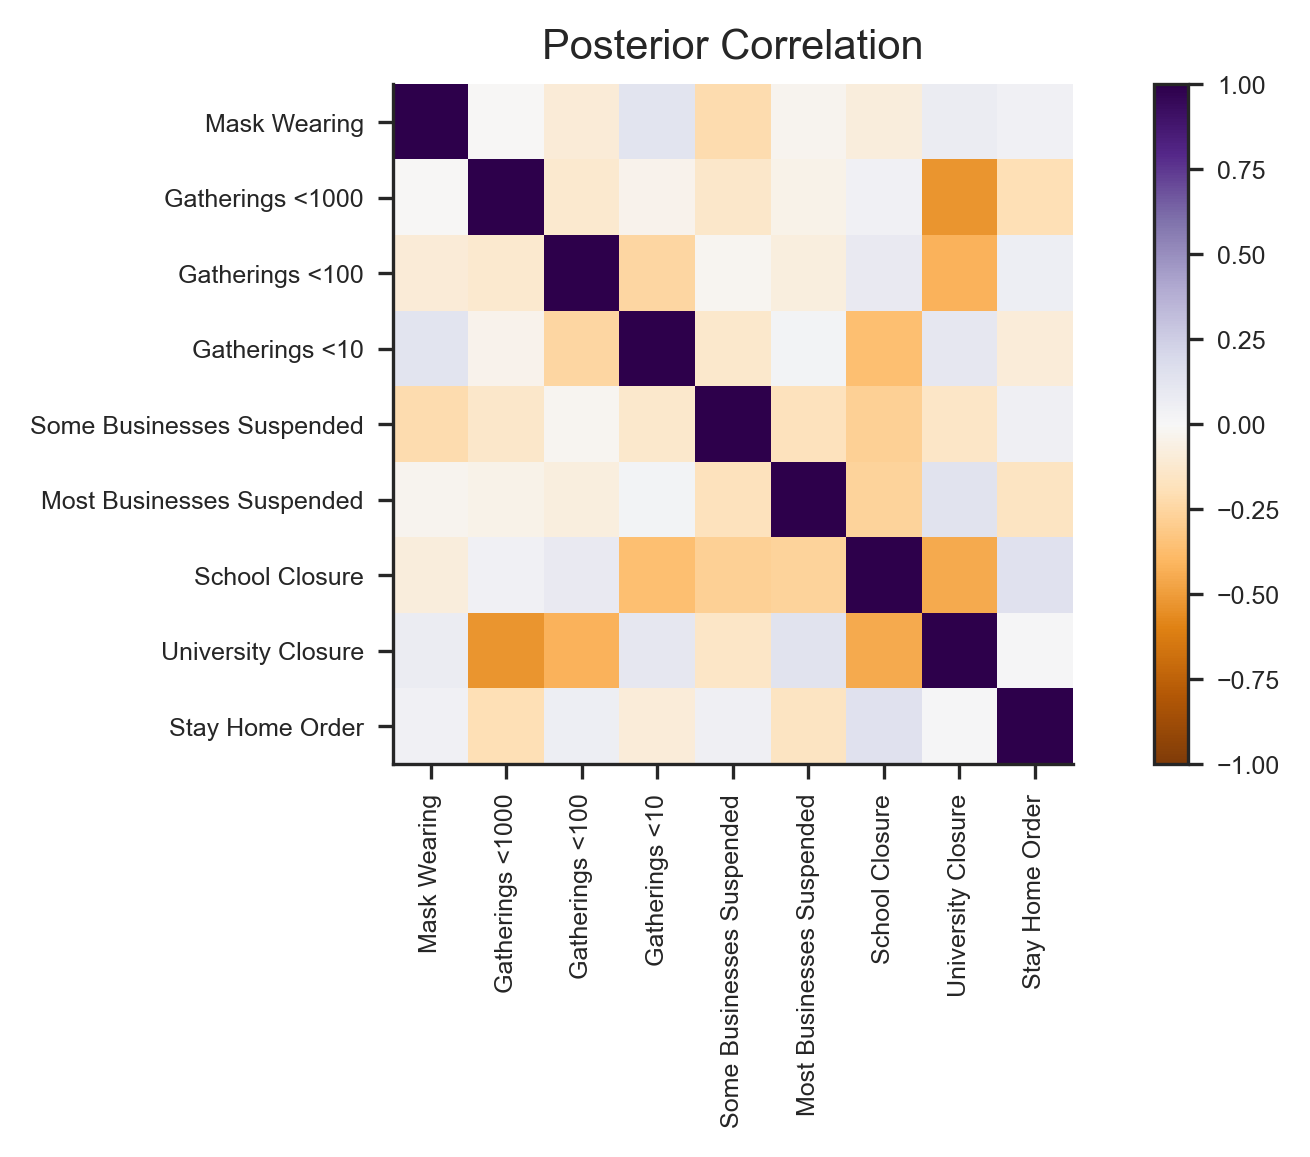

In [15]:
with model:
    model.plot_effect()

In [9]:
# save results in a pickle file
import pickle
pickle.dump(model.trace, open('final_full.pkl', 'wb'))

In [14]:
synthetic_data

{'PsiCases_log__': array([-1.02115708,  2.02624237]),
 'DeathsDelayDisp': array([7.58990112, 9.4712423 ]),
 'ObservedCases': array([[           0,            0,            0, ...,            2,
                    0,            1],
        [           0,            0,            0, ..., 100000161929,
         100000228645,  99999824673]]),
 'GI_mean': array([4.86623349, 5.2337067 ]),
 'CMReduction': array([[0.81679387, 1.00611415, 0.90619294, 1.00013919, 1.02868138,
         1.02836429, 0.90589724, 0.80666156, 0.86207774],
        [0.80908412, 0.88566813, 1.00605583, 1.02031799, 0.78859043,
         0.92110433, 0.93089043, 0.96632304, 0.51388321]]),
 'CasesDelayDisp': array([4.66196411, 6.11414939]),
 'GI_sd': array([1.98298686, 1.68654921]),
 'HyperRVar': array([0.01509521, 1.0726322 ]),
 'GrowthDeathsNoise': array([[[ 0.00633094, -0.02357397,  0.05781046, ...,  0.1082263 ,
           0.33089385,  0.02643931],
         [ 0.0230195 , -0.11145854,  0.23191466, ..., -0.0143351 ,
        

In [9]:
model.CM_Alpha.distribution

In [8]:

np.random.poisson(5.18835476e+20)

ValueError: lam value too large

In [14]:
np.array(5.18835476e+40, dtype=np.float64)

array(5.18835476e+40)

In [10]:
pm.NegativeBinomial.dist(10e20, 1).random()

ValueError: lam value too large

In [15]:
with DefaultModel(data) as model_actual:
    model_actual.build_model(**ep.get_model_build_dict())
    

npi CM_Alpha


In [ ]:
with model_actual:
    model_actual.trace = pm.sample(500, tune=500, cores=2, chains=1, max_treedepth=12, target_accept=0.925)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [DeathsDelayDisp, DeathsDelayMean, InitialSizeDeaths_log, CasesDelayDisp, CasesDelayMean, InitialSizeCases_log, PsiDeaths, PsiCases, GrowthDeathsNoise, GrowthCasesNoise, GI_sd, GI_mean, RegionLogR_noise, HyperRVar, CM_Alpha]


In [12]:
import sys

In [13]:
print(sys.version)

3.8.2 (v3.8.2:7b3ab5921f, Feb 24 2020, 17:52:18) 
[Clang 6.0 (clang-600.0.57)]


In [15]:
100000161929

100000161929

In [17]:
100000161929

100000161929.0

In [ ]:
sample_prior_predictive